In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

file_path = '/content/800subset_user_ratings.csv'
ratings_df = pd.read_csv(file_path)

ratings_df = ratings_df.iloc[:, 1:]

ratings_df.replace(0, np.nan, inplace=True)

In [12]:
Tnu = ratings_df.shape[0]
print(f"\nTotal Number of Users (Tnu): {Tnu}")

Tni = ratings_df.shape[1]
print(f"Total Number of Items (Tni): {Tni}")

ratings_count = ratings_df.count()
print("\nNumber of Ratings for Each Product:")
print(ratings_count)


Total Number of Users (Tnu): 799
Total Number of Items (Tni): 6

Number of Ratings for Each Product:
cleaned spiderman noway home    276
cleaned doctorstrange           220
cleaned thor love thunder       767
cleaned black panther           303
cleaned antman                  719
cleaned deadpool wolverine      281
dtype: int64


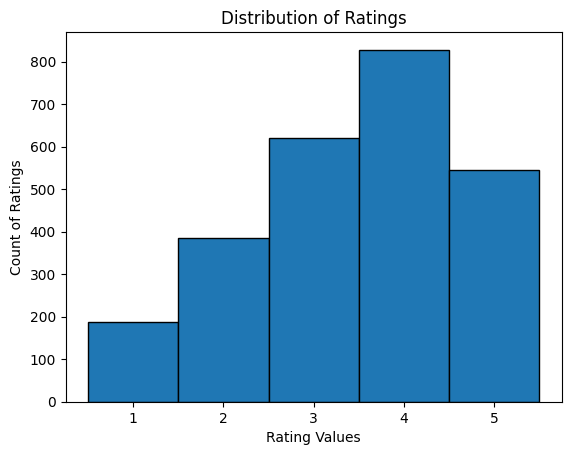

In [4]:
rating_values = ratings_df.values.flatten()
rating_values = rating_values[~np.isnan(rating_values)]
plt.hist(rating_values, bins=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5], edgecolor='black')
plt.title('Distribution of Ratings')
plt.xlabel('Rating Values')
plt.ylabel('Count of Ratings')
plt.xticks([1, 2, 3, 4, 5])
plt.show()

In [5]:
total_possible_ratings = ratings_df.size
total_actual_ratings = ratings_df.count().sum()
sparsity = 1 - (total_actual_ratings / total_possible_ratings)
print(f"\nMatrix Sparsity: {sparsity:.2%}")

item_means = ratings_df.mean()
mean_of_means = item_means.mean()
print(f"\nOverall Average Rating (Mean of Item Means): {mean_of_means:.2f}")


Matrix Sparsity: 46.47%

Overall Average Rating (Mean of Item Means): 3.14


In [7]:
bias_items = item_means[item_means > (mean_of_means + 1)]
bias_level = len(bias_items)
print(f"Number of Biased Items: {bias_level}")
if bias_level > 0:
    print("List of Biased Items:")
    print(bias_items)

lowest_rated_items = ratings_df.count().nsmallest(2)
print("\nTwo Items with the Lowest Number of Ratings (Target Items I1 and I2):")
print(lowest_rated_items)

Number of Biased Items: 0

Two Items with the Lowest Number of Ratings (Target Items I1 and I2):
cleaned doctorstrange           220
cleaned spiderman noway home    276
dtype: int64


In [11]:
import numpy as np
import pandas as pd

file_path = '/content/800subset_user_ratings.csv'
ratings_df = pd.read_csv(file_path)

ratings_df = ratings_df.iloc[:, 1:]

ratings_df.replace(0, np.nan, inplace=True)

item_means = ratings_df.mean()
print("\nMean Ratings for Each Item:")
print(item_means)

ratings_mean_filled = ratings_df.fillna(item_means)
print("\nRatings Matrix with Mean-Filled Values (First 5 rows):")
print(ratings_mean_filled.head())

target_items = ["cleaned spiderman noway home", "cleaned doctorstrange"]
target_means = ratings_mean_filled[target_items].mean()
print("\nAverage Ratings for Target Items:")
print(target_means)

ratings_diff = ratings_mean_filled.subtract(item_means, axis=1)
print("\nDifference Between Ratings and Mean Ratings (First 5 rows):")
print(ratings_diff.head())

cov_matrix = ratings_diff.cov()
print("\nCovariance Matrix:")
print(cov_matrix)

average_cov_with_targets = cov_matrix[target_items].mean(axis=1)
top_5_peers = average_cov_with_targets.nlargest(5)
top_2_peers = average_cov_with_targets.nlargest(2)

print("\nTop 5 Peers Based on Covariance with Target Items:")
print(top_5_peers)

print("\nTop 2 Peers Based on Covariance with Target Items:")
print(top_2_peers)

reduced_space_5 = ratings_mean_filled[top_5_peers.index]
print("\nReduced Dimensional Space (Top 5 Peers):\n", reduced_space_5.head())

reduced_space_2 = ratings_mean_filled[top_2_peers.index]
print("\nReduced Dimensional Space (Top 2 Peers):\n", reduced_space_2.head())

def predict_missing_ratings(item, top_peers, ratings_df, cov_matrix):
    item_means = ratings_df.mean()
    item_mean = item_means[item]

    missing_users = ratings_df[ratings_df[item].isna()].index
    print(f"\nMissing Users for {item}: {list(missing_users)}")

    predictions = {}

    print(f"\nPredicting Missing Ratings for {item}:")
    for user in missing_users:
        print(f"\n  User: {user}")
        user_ratings = ratings_df.loc[user, top_peers.index]
        print(f"    User Ratings for Top Peers:\n{user_ratings}")

        valid_peers = user_ratings[user_ratings.notna()].index
        print(f"    Valid Peers for Prediction: {list(valid_peers)}")

        if len(valid_peers) == 0:
            predictions[user] = item_mean
            print(f"    No valid peers. Using item mean: {item_mean:.2f}")
        else:
            numerator = 0
            denominator = 0

            for peer in valid_peers:
                similarity = cov_matrix.loc[item, peer]
                rating_diff = user_ratings[peer] - item_means[peer]
                numerator += similarity * rating_diff
                denominator += abs(similarity)
                print(f"    Peer: {peer}, Similarity: {similarity:.4f}, Rating Diff: {rating_diff:.4f}")

            if denominator == 0:
                predictions[user] = item_mean
                print(f"    Denominator is zero. Using item mean: {item_mean:.2f}")
            else:
                predictions[user] = item_mean + numerator / denominator
                print(f"    Predicted Rating: {predictions[user]:.2f}")

    return predictions

all_predictions_top_5 = {}
all_predictions_top_2 = {}

for target_item in target_items:
    print(f"\n--- Predictions Using Top 5 Peers for {target_item} ---")
    predictions_top_5 = predict_missing_ratings(target_item, top_5_peers, ratings_df, cov_matrix)
    all_predictions_top_5[target_item] = predictions_top_5

    print(f"\n--- Predictions Using Top 2 Peers for {target_item} ---")
    predictions_top_2 = predict_missing_ratings(target_item, top_2_peers, ratings_df, cov_matrix)
    all_predictions_top_2[target_item] = predictions_top_2

for item, preds in all_predictions_top_5.items():
    print(f"\nPredicted Ratings for {item} (Top 5 Peers):")
    if preds:
        for user, pred in preds.items():
            print(f"User {user}: {pred:.2f}")
    else:
        print("No missing ratings to predict.")

for item, preds in all_predictions_top_2.items():
    print(f"\nPredicted Ratings for {item} (Top 2 Peers):")
    if preds:
        for user, pred in preds.items():
            print(f"User {user}: {pred:.2f}")
    else:
        print("No missing ratings to predict.")


Streaming output truncated to the last 5000 lines.
    Predicted Rating: 4.23

  User: 331
    User Ratings for Top Peers:
cleaned spiderman noway home   NaN
cleaned doctorstrange          NaN
Name: 331, dtype: float64
    Valid Peers for Prediction: []
    No valid peers. Using item mean: 2.90

  User: 335
    User Ratings for Top Peers:
cleaned spiderman noway home   NaN
cleaned doctorstrange          NaN
Name: 335, dtype: float64
    Valid Peers for Prediction: []
    No valid peers. Using item mean: 2.90

  User: 336
    User Ratings for Top Peers:
cleaned spiderman noway home   NaN
cleaned doctorstrange          NaN
Name: 336, dtype: float64
    Valid Peers for Prediction: []
    No valid peers. Using item mean: 2.90

  User: 338
    User Ratings for Top Peers:
cleaned spiderman noway home   NaN
cleaned doctorstrange          NaN
Name: 338, dtype: float64
    Valid Peers for Prediction: []
    No valid peers. Using item mean: 2.90

  User: 339
    User Ratings for Top Peers:
clean

In [17]:
import numpy as np
import pandas as pd

file_path = '/content/800subset_user_ratings.csv'
ratings_df = pd.read_csv(file_path)

ratings_df = ratings_df.iloc[:, 1:]

ratings_df.replace(0, np.nan, inplace=True)

def compute_mle_covariance_matrix(df):
    items = df.columns
    n_items = len(items)
    cov_matrix = pd.DataFrame(np.zeros((n_items, n_items)), index=items, columns=items)

    for i, item_i in enumerate(items):
        for j, item_j in enumerate(items):
            if i <= j:
                common_users = df[[item_i, item_j]].dropna()
                if len(common_users) > 0:
                    covariance = common_users.cov().iloc[0, 1]
                else:
                    covariance = 0
                cov_matrix.loc[item_i, item_j] = covariance
                cov_matrix.loc[item_j, item_i] = covariance
    return cov_matrix

cov_matrix_mle = compute_mle_covariance_matrix(ratings_df)
print("\nCovariance Matrix using MLE (Step 3.3.1):")
print(cov_matrix_mle)

target_items = ["cleaned spiderman noway home", "cleaned doctorstrange"]
average_cov_with_targets_mle = cov_matrix_mle[target_items].mean(axis=1)
top_5_peers_mle = average_cov_with_targets_mle.nlargest(5)
top_2_peers_mle = average_cov_with_targets_mle.nlargest(2)

print("\nTop 5 Peers Based on Covariance with Target Items (Step 3.3.2):")
print(top_5_peers_mle)

print("\nTop 2 Peers Based on Covariance with Target Items (Step 3.3.2):")
print(top_2_peers_mle)

reduced_space_5_mle = ratings_df[top_5_peers_mle.index]
print("\nReduced Dimensional Space (Top 5 Peers, Step 3.3.3):\n", reduced_space_5_mle.head())

reduced_space_2_mle = ratings_df[top_2_peers_mle.index]
print("\nReduced Dimensional Space (Top 2 Peers, Step 3.3.5):\n", reduced_space_2_mle.head())





Covariance Matrix using MLE (Step 3.3.1):
                              cleaned spiderman noway home  \
cleaned spiderman noway home                      1.194532   
cleaned doctorstrange                             0.436726   
cleaned thor love thunder                         0.150936   
cleaned black panther                             0.483128   
cleaned antman                                   -0.020308   
cleaned deadpool wolverine                        0.407726   

                              cleaned doctorstrange  \
cleaned spiderman noway home               0.436726   
cleaned doctorstrange                      1.025794   
cleaned thor love thunder                  0.056947   
cleaned black panther                      0.546210   
cleaned antman                             0.188298   
cleaned deadpool wolverine                 0.530168   

                              cleaned thor love thunder  \
cleaned spiderman noway home                   0.150936   
cleaned doctorstra